# Impact of Continuity Correction for Barrier Options

This notebook explores the concept and impact of using a continuity correction when pricing barrier options with Monte Carlo simulations that use discrete time steps.

## Discrete vs. Continuous Monitoring

-   **Continuous Monitoring:** In theory, many barrier option contracts specify that the barrier is active continuously throughout the option's life. If the underlying asset price touches or crosses the barrier at *any instant*, the knock-out or knock-in event occurs.
-   **Discrete Monitoring in Simulations:** Monte Carlo simulations, by their nature, discretize time into a finite number of steps ($N_{steps}$). The asset price is only observed at these discrete points. This means a path could potentially cross and recross a barrier *between* two observation points without being detected, leading to a mispricing of the option.
    -   For **knock-out** options, discrete monitoring tends to *underestimate* the probability of hitting the barrier, thus *overvaluing* the option.
    -   For **knock-in** options, discrete monitoring tends to *underestimate* the probability of hitting the barrier, thus *undervaluing* the option.

## Continuity Correction

To bridge the gap between discrete simulation and the assumption of continuous monitoring, a **continuity correction** can be applied. This typically involves adjusting the barrier level slightly to account for the probability of unobserved barrier breaches between discrete time steps.

A common correction, proposed by Broadie, Glasserman, and Kou (1997), adjusts the barrier $B$ to an effective barrier $B_{eff}$:

$B_{eff} = B \cdot \exp(\pm \beta \cdot \sigma \cdot \sqrt{\Delta t})$

Where:
-   $B$ is the original barrier.
-   $\beta \approx 0.5826$ (derived from properties of Brownian motion).
-   $\sigma$ is the volatility of the underlying asset.
-   $\Delta t = T / N_{steps}$ is the length of a discrete time step.
-   The sign of the adjustment depends on the option type (e.g., for a down-and-out option, the effective barrier is shifted slightly lower to increase the chance of a (corrected) knockout).

This notebook will:
1.  Price a barrier option using standard discrete monitoring.
2.  Price the same option using the `continuous_approx` setting in our `BarrierOptionsPricer`, which applies this continuity correction.
3.  Compare the results and discuss the impact.
4.  (Optionally) Show how the discretely monitored price approaches the continuously corrected price as the number of time steps ($N_{steps}$) increases.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union, Optional, List, Dict # Added List, Dict for type hinting
import time

# For confidence interval calculation - ensure scipy is installed
try:
    from scipy import stats
except ImportError:
    print("Warning: scipy.stats not found. Using a basic approximation for confidence interval critical values.")
    class stats_fallback: # Renamed to avoid conflict
        class norm:
            @staticmethod
            def ppf(q):
                if abs(q - 0.975) < 1e-3: return 1.96
                elif abs(q - 0.995) < 1e-3: return 2.576
                import math # Lazy import math
                # A more robust approximation for inverse normal CDF
                return math.sqrt(2) * math.erfcinv(2.0 - 2.0*q) if q > 0 and q < 1 else 0 # erfcinv(x) = erfinv(1-x)
    stats = stats_fallback


# Set a seed for reproducibility
np.random.seed(888)


## BarrierOptionsPricer Class and Helper Functions

The following cell contains the full `BarrierOptionsPricer` class definition and the `print_detailed_results` helper function from the `barrier_options_pricer.py` file. We include them here to make the notebook self-contained and runnable.


In [3]:
class BarrierOptionsPricer:
    """
    Monte Carlo pricer for barrier options using Geometric Brownian Motion.
    """
    
    def __init__(self):
        self.valid_option_types = [
            'down_and_out_call', 'down_and_out_put',
            'up_and_out_call', 'up_and_out_put',
            'down_and_in_call', 'down_and_in_put',
            'up_and_in_call', 'up_and_in_put'
        ]
    
    def simulate_gbm_paths(self, S0: float, r: float, sigma: float, T: float, 
                          N_sim: int, N_steps: int) -> np.ndarray:
        dt = T / N_steps
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        random_shocks = np.random.normal(0, 1, (N_sim, N_steps))
        paths = np.zeros((N_sim, N_steps + 1))
        paths[:, 0] = S0
        for i in range(N_steps):
            paths[:, i + 1] = paths[:, i] * np.exp(drift + diffusion * random_shocks[:, i])
        return paths
    
    def apply_continuity_correction(self, B: float, sigma: float, T: float, 
                                  N_steps: int, option_type: str) -> float:
        dt = T / N_steps
        beta_correction_factor = 0.5826 # From Broadie, Glasserman, Kou (1997)
        correction_amount = beta_correction_factor * sigma * np.sqrt(dt)
        
        B_adj = B
        # Adjust barrier: for 'out' options, make it easier to hit (more conservative price).
        # For 'in' options, make it harder to hit (more conservative price).
        if 'down_and_out' in option_type: # Barrier B. Price S0 > B. Knocks out if S <= B.
            B_adj = B * np.exp(correction_amount)  # Shift barrier slightly higher (harder to stay above)
        elif 'up_and_out' in option_type:   # Barrier B. Price S0 < B. Knocks out if S >= B.
            B_adj = B * np.exp(-correction_amount) # Shift barrier slightly lower (harder to stay below)
        elif 'down_and_in' in option_type:  # Barrier B. Price S0 > B. Knocks in if S <= B.
            B_adj = B * np.exp(-correction_amount) # Shift barrier slightly lower (easier to hit for knock-in)
        elif 'up_and_in' in option_type:    # Barrier B. Price S0 < B. Knocks in if S >= B.
            B_adj = B * np.exp(correction_amount)  # Shift barrier slightly higher (easier to hit for knock-in)
        return B_adj
    
    def calculate_barrier_payoff(self, path: np.ndarray, K: float, B: float, 
                               option_type: str, T: float, r_rate: float,
                               monitoring_type: str = 'discrete', sigma_for_correction: Optional[float] = None) -> float:
        if option_type not in self.valid_option_types:
            raise ValueError(f"Invalid option type. Must be one of {self.valid_option_types}")
        
        B_eff = B # Effective barrier
        if monitoring_type == 'continuous_approx':
            if sigma_for_correction is None:
                # This should ideally come from the pricer's main sigma
                raise ValueError("sigma_for_correction must be provided for continuous_approx monitoring.")
            N_steps = len(path) - 1
            if N_steps == 0: # Avoid division by zero if T=0 or N_steps=0
                 B_eff = B # No correction if no steps
            else:
                B_eff = self.apply_continuity_correction(B, sigma_for_correction, T, N_steps, option_type)

        knocked_out = False
        knocked_in = False
        
        # Initial check for S0 relative to barrier.
        # For 'out' options, if S0 already breaches, it's out.
        # For 'in' options, if S0 already fulfills condition, it's in from start (for this path logic).
        if 'down_and_out' in option_type and path[0] <= B_eff: return 0.0
        if 'up_and_out' in option_type and path[0] >= B_eff: return 0.0
        if 'down_and_in' in option_type and path[0] <= B_eff: knocked_in = True
        if 'up_and_in' in option_type and path[0] >= B_eff: knocked_in = True


        # Path monitoring (excluding S0 if already handled for 'in' options)
        # For 'in' options, if already knocked_in by S0, no need to check path for knock-in event.
        # For 'out' options, path must be checked.
        start_idx = 1 # Start checking from S1
        
        if not (('in' in option_type) and knocked_in): # Only monitor if not already knocked-in
            for i in range(start_idx, len(path)):
                price_step = path[i]
                if 'down' in option_type:
                    if price_step <= B_eff:
                        if 'out' in option_type: knocked_out = True; break
                        if 'in' in option_type: knocked_in = True; break 
                elif 'up' in option_type:
                    if price_step >= B_eff:
                        if 'out' in option_type: knocked_out = True; break
                        if 'in' in option_type: knocked_in = True; break
        
        S_T = path[-1]
        intrinsic_payoff = max(S_T - K, 0) if 'call' in option_type else max(K - S_T, 0)
        
        payoff = 0.0
        if 'out' in option_type and not knocked_out: payoff = intrinsic_payoff
        elif 'in' in option_type and knocked_in: payoff = intrinsic_payoff
        return payoff

    def monte_carlo_pricer(self, S0: float, K: float, B: float, T: float,
                          r_rate: float, sigma: float, option_type: str,
                          N_sim: int, N_steps: int,
                          monitoring_type: str = 'discrete',
                          confidence_level: float = 0.95,
                          antithetic: bool = False) -> Tuple[float, float, float, dict]:
        start_time = time.time()
        actual_N_sim_for_shocks = N_sim
        if antithetic:
            actual_N_sim_for_shocks = (N_sim + 1) // 2 if N_sim % 2 != 0 else N_sim // 2
        
        dt = T / N_steps if N_steps > 0 else 0 # Handle T=0 or N_steps=0
        drift = (r_rate - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) if dt > 0 else 0
        random_shocks_orig = np.random.normal(0, 1, (actual_N_sim_for_shocks, N_steps))
        all_payoffs = []

        paths_orig = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
        paths_orig[:, 0] = S0
        if N_steps > 0:
            for i in range(N_steps):
                paths_orig[:, i + 1] = paths_orig[:, i] * np.exp(drift + diffusion * random_shocks_orig[:, i])
        else: # If T=0 or N_steps=0, path is just S0
            paths_orig[:, :] = S0


        for j in range(actual_N_sim_for_shocks):
            payoff_orig = self.calculate_barrier_payoff(paths_orig[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
            all_payoffs.append(payoff_orig)

        if antithetic:
            random_shocks_anti = -random_shocks_orig
            paths_anti = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
            paths_anti[:, 0] = S0
            if N_steps > 0:
                for i in range(N_steps):
                    paths_anti[:, i + 1] = paths_anti[:, i] * np.exp(drift + diffusion * random_shocks_anti[:, i])
            else:
                 paths_anti[:, :] = S0
            
            for j in range(actual_N_sim_for_shocks):
                payoff_anti = self.calculate_barrier_payoff(paths_anti[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
                all_payoffs.append(payoff_anti)
        
        all_payoffs_arr = np.array(all_payoffs)
        mean_payoff = np.mean(all_payoffs_arr) if len(all_payoffs_arr) > 0 else 0.0
        option_price = mean_payoff * np.exp(-r_rate * T)
        
        std_payoffs = np.std(all_payoffs_arr, ddof=1) if len(all_payoffs_arr) > 1 else 0.0
        n_total_effective_paths = len(all_payoffs_arr)
        standard_error_payoff = std_payoffs / np.sqrt(n_total_effective_paths) if n_total_effective_paths > 0 else 0.0
        
        alpha_ci = 1 - confidence_level
        critical_value = stats.norm.ppf(1 - alpha_ci/2)
        margin_of_error_price = critical_value * standard_error_payoff * np.exp(-r_rate * T)
        confidence_lower = option_price - margin_of_error_price
        confidence_upper = option_price + margin_of_error_price
        
        computation_time = time.time() - start_time
        mc_error_price_val = standard_error_payoff * np.exp(-r_rate * T)
        
        barrier_hit_count = 0
        # For barrier hit stats, we need all paths that were used in payoff calculation
        # This logic needs to be robust for N_steps = 0
        if N_steps > 0:
            combined_paths_for_stats = paths_orig
            if antithetic and actual_N_sim_for_shocks > 0:
                paths_anti_for_stats = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
                paths_anti_for_stats[:, 0] = S0
                for k_sim_idx in range(actual_N_sim_for_shocks):
                     for i_step in range(N_steps):
                        paths_anti_for_stats[k_sim_idx, i_step + 1] = paths_anti_for_stats[k_sim_idx, i_step] * np.exp(drift + diffusion * (-random_shocks_orig[k_sim_idx, i_step]))
                combined_paths_for_stats = np.vstack((paths_orig, paths_anti_for_stats))

            for path_stat in combined_paths_for_stats:
                B_eff_stat = B
                if monitoring_type == 'continuous_approx':
                     B_eff_stat = self.apply_continuity_correction(B, sigma, T, N_steps, option_type)
                hit_this_path = False
                if 'down' in option_type:
                    if np.any(path_stat <= B_eff_stat): hit_this_path = True
                elif 'up' in option_type:
                    if np.any(path_stat >= B_eff_stat): hit_this_path = True
                if hit_this_path: barrier_hit_count +=1
            barrier_hit_percentage = (barrier_hit_count / len(combined_paths_for_stats)) * 100 if len(combined_paths_for_stats) > 0 else 0.0
        else: # N_steps = 0, barrier check is only at S0
            B_eff_stat = B # No dt for correction if N_steps is 0
            if monitoring_type == 'continuous_approx' and T > 0: # Edge case: T>0 but N_steps=0, correction is tricky. Assume B_eff = B.
                 pass # Or handle as error / specific logic for T>0, N_steps=0

            if 'down' in option_type:
                if S0 <= B_eff_stat: barrier_hit_count = n_total_effective_paths
            elif 'up' in option_type:
                if S0 >= B_eff_stat: barrier_hit_count = n_total_effective_paths
            barrier_hit_percentage = (barrier_hit_count / n_total_effective_paths) * 100 if n_total_effective_paths > 0 else 0.0


        statistics = {
            'mean_payoff': mean_payoff, 'std_payoff': std_payoffs,
            'standard_error_payoff': standard_error_payoff, 'mc_error_price': mc_error_price_val,
            'barrier_hit_percentage': barrier_hit_percentage, 'computation_time': computation_time,
            'effective_simulations_used': n_total_effective_paths, 'confidence_used': confidence_level,
            'convergence_ratio': mc_error_price_val / option_price if abs(option_price) > 1e-9 else float('inf')
        }
        return option_price, confidence_lower, confidence_upper, statistics

    def analyze_convergence(self, S0: float, K: float, B: float, T: float,
                           r_rate: float, sigma: float, option_type: str,
                           N_steps: int, sim_counts: Optional[List[int]] = None,
                           monitoring_type: str = 'discrete', antithetic: bool = False) -> Dict:
        if sim_counts is None:
            sim_counts = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000]
        prices, errors, times = [], [], []
        for N_sim_val in sim_counts:
            price, _, _, stats = self.monte_carlo_pricer(
                S0, K, B, T, r_rate, sigma, option_type, N_sim_val, N_steps, monitoring_type, antithetic=antithetic
            )
            prices.append(price)
            errors.append(stats['mc_error_price'])
            times.append(stats['computation_time'])
        return {'sim_counts': sim_counts, 'prices': prices, 'errors': errors, 'computation_times': times}

    def sensitivity_analysis(self, S0: float, K: float, B: float, T: float,
                           r_rate: float, sigma: float, option_type: str,
                           N_sim: int, N_steps: int,
                           parameter_to_vary: str, range_pct: float = 0.2,
                           num_points: int = 11,
                           monitoring_type: str = 'discrete', antithetic: bool = False) -> Dict:
        base_params = {'S0': S0, 'K': K, 'B': B, 'T': T, 'r_rate': r_rate, 'sigma': sigma}
        if parameter_to_vary not in base_params:
            raise ValueError(f"Invalid parameter: {parameter_to_vary}")
        base_value = base_params[parameter_to_vary]
        min_val, max_val = base_value * (1 - range_pct), base_value * (1 + range_pct)
        if parameter_to_vary == 'B':
            if 'down' in option_type and max_val >= S0 : max_val = S0 * 0.999 
            if 'up' in option_type and min_val <= S0 : min_val = S0 * 1.001
            if min_val <=0 : min_val = 0.01 
        if parameter_to_vary == 'S0':
             if 'down' in option_type and min_val <= B : min_val = B * 1.001
             if 'up' in option_type and max_val >= B : max_val = B * 0.999
        param_values = np.linspace(min_val, max_val, num_points)
        if parameter_to_vary == 'sigma': param_values = np.maximum(param_values, 0.001)
        
        prices_sensitivity = []
        for param_val in param_values:
            current_params_iter = base_params.copy()
            current_params_iter[parameter_to_vary] = param_val
            price, _, _, _ = self.monte_carlo_pricer(
                current_params_iter['S0'], current_params_iter['K'], current_params_iter['B'],
                current_params_iter['T'], current_params_iter['r_rate'], current_params_iter['sigma'],
                option_type, N_sim, N_steps, monitoring_type, antithetic=antithetic
            )
            prices_sensitivity.append(price)
        base_price_idx = np.argmin(np.abs(param_values - base_value))
        return {
            'parameter_varied': parameter_to_vary, 'parameter_values': param_values,
            'option_prices': prices_sensitivity, 'base_parameter_value': base_value,
            'base_option_price': prices_sensitivity[base_price_idx]
        }

# Helper function to print results
def print_detailed_results(price: float, conf_lower: float, conf_upper: float, 
                          stats: dict, option_params: dict, monitoring_desc: str):
    print(f"\n--- Results for: {option_params['option_type'].replace('_', ' ').title()} ({monitoring_desc}) ---")
    print(f"Estimated Option Price: ${price:.6f}")
    print(f"  {stats['confidence_used']*100:.0f}% CI: [${conf_lower:.6f}, ${conf_upper:.6f}] (Error: ±${stats['mc_error_price']:.6f})")
    if abs(price) > 1e-9:
        print(f"  MC Error as % of Price: {(stats['mc_error_price']/price)*100:.3f}%")
    print(f"  Barrier Hit Percentage: {stats['barrier_hit_percentage']:.2f}%")
    print(f"  Computation Time: {stats['computation_time']:.3f} seconds")
    if 'adjusted_barrier' in stats:
        print(f"  Adjusted Barrier (for continuous approx): {stats['adjusted_barrier']:.4f}")



## Define Base Parameters for Analysis

We will use a Down-and-Out Call option for this demonstration. Such an option is typically sensitive to how the barrier monitoring is handled, especially if the spot price is relatively close to the barrier or volatility is high.


In [4]:
# Parameters for the option to be analyzed
base_params_cc = {
    'S0': 100.0,
    'K': 100.0,      # At-the-money
    'B': 95.0,       # Barrier relatively close to S0
    'T': 0.25,       # Shorter maturity (e.g., 3 months)
    'r_rate': 0.05,
    'sigma': 0.30,   # Moderately high volatility
    'option_type': 'down_and_out_call',
    'N_sim': 200000, # Use a decent number of simulations for stability
    'N_steps': 50,   # Start with a moderate number of steps for discrete monitoring
    'antithetic': True # Use antithetic to reduce some noise
}

print("Base Option Parameters for Continuity Correction Analysis:")
for key, value in base_params_cc.items():
    print(f"- {key}: {value}")


Base Option Parameters for Continuity Correction Analysis:
- S0: 100.0
- K: 100.0
- B: 95.0
- T: 0.25
- r_rate: 0.05
- sigma: 0.3
- option_type: down_and_out_call
- N_sim: 200000
- N_steps: 50
- antithetic: True


### 1. Price with Discrete Monitoring

First, let's price the option using standard discrete monitoring at each of the `N_steps`.


In [5]:
pricer_cc = BarrierOptionsPricer()

print(f"Pricing with Discrete Monitoring (N_steps = {base_params_cc['N_steps']})...")
price_discrete, ci_l_discrete, ci_u_discrete, stats_discrete = pricer_cc.monte_carlo_pricer(
    **base_params_cc,
    monitoring_type='discrete'
)
print_detailed_results(price_discrete, ci_l_discrete, ci_u_discrete, stats_discrete, base_params_cc, "Discrete Monitoring")


Pricing with Discrete Monitoring (N_steps = 50)...

--- Results for: Down And Out Call (Discrete Monitoring) ---
Estimated Option Price: $4.807442
  95% CI: [$4.765536, $4.849348] (Error: ±$0.021381)
  MC Error as % of Price: 0.445%
  Barrier Hit Percentage: 67.00%
  Computation Time: 1.478 seconds


### 2. Price with Continuous Monitoring Approximation

Next, we price the same option, but we set `monitoring_type='continuous_approx'`. The `BarrierOptionsPricer` will internally call `apply_continuity_correction` to adjust the barrier level.


In [6]:
print(f"\nPricing with Continuous Monitoring Approximation (N_steps = {base_params_cc['N_steps']})...")
price_continuous, ci_l_continuous, ci_u_continuous, stats_continuous = pricer_cc.monte_carlo_pricer(
    **base_params_cc,
    monitoring_type='continuous_approx'
)
# For display, let's get the adjusted barrier that was used
# The sigma used for correction inside calculate_barrier_payoff is base_params_cc['sigma']
adjusted_B = pricer_cc.apply_continuity_correction(
    base_params_cc['B'], 
    base_params_cc['sigma'], 
    base_params_cc['T'], 
    base_params_cc['N_steps'], 
    base_params_cc['option_type']
)
stats_continuous['adjusted_barrier'] = adjusted_B # Store it for printing

print_detailed_results(price_continuous, ci_l_continuous, ci_u_continuous, stats_continuous, base_params_cc, "Continuous Approx.")

print(f"\nOriginal Barrier: {base_params_cc['B']:.4f}")
print(f"Adjusted Barrier used for 'continuous_approx': {adjusted_B:.4f}")

price_difference = price_discrete - price_continuous
print(f"\nPrice Difference (Discrete - Continuous Approx.): ${price_difference:.6f}")
if abs(price_continuous) > 1e-9:
    print(f"Percentage Difference: { (price_difference / price_continuous) * 100:.2f}%")



Pricing with Continuous Monitoring Approximation (N_steps = 50)...

--- Results for: Down And Out Call (Continuous Approx.) ---
Estimated Option Price: $4.222620
  95% CI: [$4.182200, $4.263040] (Error: ±$0.020623)
  MC Error as % of Price: 0.488%
  Barrier Hit Percentage: 72.97%
  Computation Time: 1.666 seconds
  Adjusted Barrier (for continuous approx): 96.1814

Original Barrier: 95.0000
Adjusted Barrier used for 'continuous_approx': 96.1814

Price Difference (Discrete - Continuous Approx.): $0.584822
Percentage Difference: 13.85%


### 3. Impact of Increasing Time Steps ($N_{steps}$)

The continuity correction aims to make the discrete simulation behave more like a continuous one. As we increase the number of discrete monitoring steps ($N_{steps}$), the discretely monitored price should converge towards the price obtained with the continuity correction (or a true continuously monitored price if one could simulate it perfectly).

Let's observe this by pricing the option with discrete monitoring for an increasing number of time steps and compare it to the price obtained using the continuity correction with a fixed (but reasonable) number of steps.



Reference 'Continuous Approx.' Price (with N_steps=50): $4.222620

Analyzing impact of N_steps on discretely monitored price:
  Running discrete monitoring with N_steps = 20...
  Running discrete monitoring with N_steps = 50...
  Running discrete monitoring with N_steps = 100...
  Running discrete monitoring with N_steps = 252...


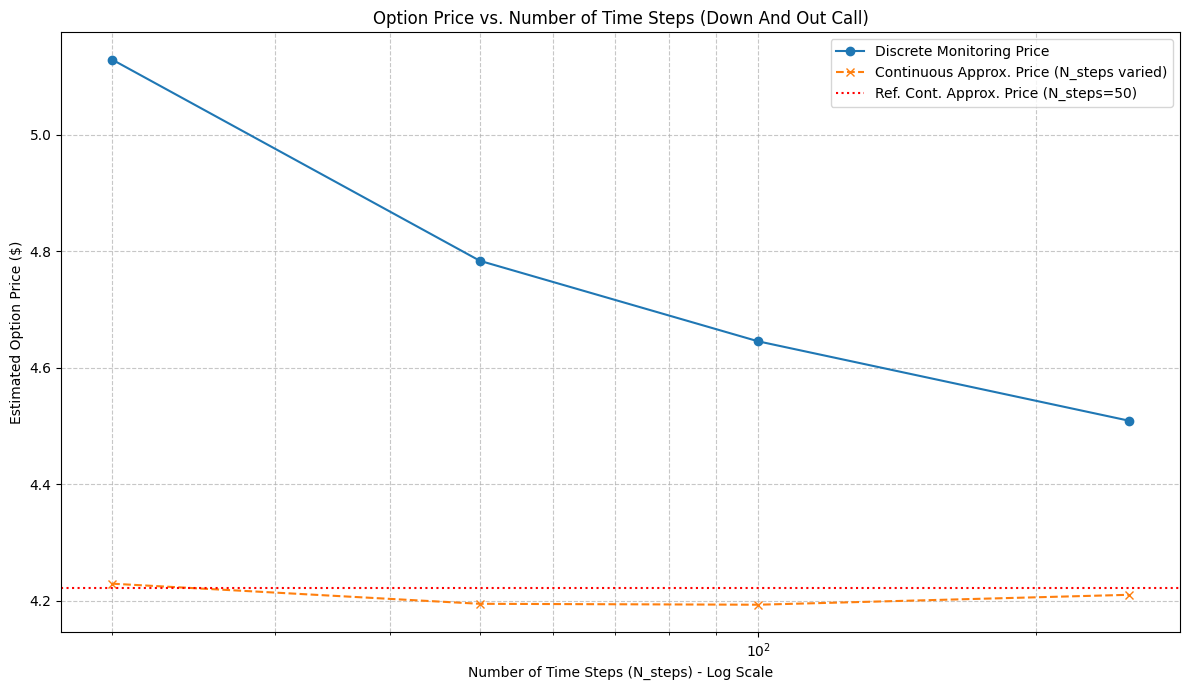


Comparison Table (Price vs N_steps):
------------------------------------------------------------
N_steps    Discrete Price       Cont. Approx. Price 
------------------------------------------------------------
20         $5.129102            $4.229221           
50         $4.783570            $4.194662           
100        $4.645364            $4.193086           
252        $4.508994            $4.210128           


In [7]:
n_steps_values = [20, 50, 100, 252] # Fewer steps for quicker demo
# For more accuracy, one might use: [50, 100, 252, 500, 1000, 2000, 5000]

discrete_prices_vs_nsteps = []
continuous_approx_prices_vs_nsteps = [] # Will use a fixed N_steps for the 'target' continuous price

# Get a 'target' price using continuous correction with a high number of steps
# Or use the one calculated before with N_steps=base_params_cc['N_steps']
target_continuous_price = price_continuous 
print(f"\nReference 'Continuous Approx.' Price (with N_steps={base_params_cc['N_steps']}): ${target_continuous_price:.6f}")

print("\nAnalyzing impact of N_steps on discretely monitored price:")
for n_s in n_steps_values:
    print(f"  Running discrete monitoring with N_steps = {n_s}...")
    current_params_nsteps = base_params_cc.copy()
    current_params_nsteps['N_steps'] = n_s
    
    price_d, _, _, _ = pricer_cc.monte_carlo_pricer(
        **current_params_nsteps,
        monitoring_type='discrete'
    )
    discrete_prices_vs_nsteps.append(price_d)
    
    # For comparison, also run continuous approx with these N_steps
    # This shows how CC itself changes with N_steps (due to dt in correction formula)
    price_c_approx, _, _, stats_c_approx = pricer_cc.monte_carlo_pricer(
        **current_params_nsteps,
        monitoring_type='continuous_approx'
    )
    continuous_approx_prices_vs_nsteps.append(price_c_approx)


# Plotting the results
plt.figure(figsize=(12, 7))
plt.plot(n_steps_values, discrete_prices_vs_nsteps, marker='o', linestyle='-', label='Discrete Monitoring Price')
plt.plot(n_steps_values, continuous_approx_prices_vs_nsteps, marker='x', linestyle='--', label=f'Continuous Approx. Price (N_steps varied)')
plt.axhline(target_continuous_price, color='red', linestyle=':', label=f'Ref. Cont. Approx. Price (N_steps={base_params_cc["N_steps"]})')

plt.xscale('log') # Often helps to see convergence pattern
plt.title(f'Option Price vs. Number of Time Steps ({base_params_cc["option_type"].replace("_", " ").title()})')
plt.xlabel('Number of Time Steps (N_steps) - Log Scale')
plt.ylabel('Estimated Option Price ($)')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("\nComparison Table (Price vs N_steps):")
print("-" * 60)
print(f"{'N_steps':<10} {'Discrete Price':<20} {'Cont. Approx. Price':<20}")
print("-" * 60)
for i, n_s in enumerate(n_steps_values):
    print(f"{n_s:<10} ${discrete_prices_vs_nsteps[i]:<19.6f} ${continuous_approx_prices_vs_nsteps[i]:<19.6f}")


## Conclusion and Observations

-   **Price Difference:** As observed, the option price calculated with discrete monitoring is typically different from the one calculated using the continuity correction. For a Down-and-Out Call, the discrete price is often higher because the probability of knockout is underestimated. The continuity correction (by effectively making the barrier easier to hit from the perspective of the original barrier) lowers the option price, bringing it closer to what a true continuously monitored option might be worth.

-   **Impact of $N_{steps}$:**
    -   The plot "Option Price vs. Number of Time Steps" shows that as $N_{steps}$ increases, the price from discrete monitoring generally converges towards the price obtained with the continuity correction (or a more stable continuously corrected price if $N_{steps}$ for that was also very high).
    -   The continuity-corrected price itself also changes slightly with $N_{steps}$ because $\Delta t$ is part of the correction formula. However, this change is usually smaller than the change in the purely discrete price.

-   **Practical Implications:**
    -   When pricing barrier options that are theoretically continuously monitored, using a continuity correction is crucial if the number of simulation steps is not extremely large.
    -   Without correction, a low $N_{steps}$ can lead to significant mispricing.
    -   The choice of $N_{steps}$ involves a trade-off: higher $N_{steps}$ improves accuracy for discrete monitoring (bringing it closer to continuous) but increases computation time. The continuity correction offers a way to get better accuracy for a given (moderate) $N_{steps}$.

This analysis highlights the importance of understanding the monitoring features of barrier options and how simulation parameters can affect the valuation.
